# Stacking Ensemble Model

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from numpy import dstack
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, GlobalMaxPooling1D, Conv1D, MaxPooling1D, concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.layers import Bidirectional,LSTM,GlobalAveragePooling1D
from tensorflow.keras.utils import plot_model
import pydot as pyd
from keras.utils.vis_utils import model_to_dot
from numpy import argmax
import csv
from tensorflow.keras.callbacks import EarlyStopping # Callback for early stopping
import matplotlib as matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import graphviz

In [ ]:
# Read test data
test_index = list()  
with open('data/test.csv', 'r', encoding='utf8') as f:
    for line in f:
        t = line.split(',')
        test_index.append(int(t[0]))

In [ ]:
X_val_cnn = np.load('data/X_val_cnn.npy')
X_val_deepwlk = np.load('data/X_val_deepwlk.npy')
y_validation = np.load('data/Y_val.npy')

X_test_cnn = np.load('data/X_test_cnn.npy')
X_test_deepwlk = np.load('data/X_test_deepwlk.npy')

In [ ]:
# Splitting Train and Validation sets for text and graph features
from sklearn.model_selection import train_test_split
X_tra, X_val, y_tra, y_val = train_test_split(X_val_cnn, y_validation, train_size=0.60, random_state=233)
X_tra_graph, X_val_graph, y_tra_graph, y_val_graph = train_test_split(X_val_deepwlk, y_validation, train_size=0.60, random_state=233)

In [ ]:
def plot_history(hs, epochs, metric):
    print()
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 2))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()

In [ ]:
# load models from file
def load_all_models():
    all_models = list()
    # define filename for this ensemble
    deepwalk = 'classification_models/model_mlp_deepwalk.h5'
    cnn = 'classification_models/model_cnn.h5'

    # load model from file
    deepwalkmdl = load_model(deepwalk)
    print('>loaded %s' % deepwalk)
    cnnmdl = load_model(cnn)
    print('>loaded %s' % cnn)

    # add to list of members
    all_models.append(deepwalkmdl)
    all_models.append(cnnmdl)

    return all_models


# define stacked model from multiple member input models
def define_stacked_model(members):
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            # make not trainable
            layer.trainable = False
            # rename to avoid 'unique layer name' issue
            layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
    # define multi-headed input
    ensemble_visible = [model.input for model in members]
    print("ensemble_visible ",ensemble_visible)
    # concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)
    hidden = Dense(50, activation='relu')(merge)
    output = Dense(15, activation='softmax')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    # compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
    early_stopping = EarlyStopping(
    monitor='loss',
    patience=100,
    verbose=1,
    restore_best_weights=True
    )
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
    # fit model
    hist = model.fit(X, inputy, epochs=500, verbose=1, batch_size=256, callbacks=[early_stopping], 
                     validation_split=0.1, shuffle=True)
    return hist
    
# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
    # make prediction
    return model.predict(X, verbose=1)


# load all models
members = load_all_models()
print('Loaded %d models' % len(members))
# define ensemble model
stacked_model = define_stacked_model(members)
# fit stacked model on test dataset
# hist = fit_stacked_model(stacked_model,[X_val_deepwlk,X_val_cnn], y_validation)
hist = fit_stacked_model(stacked_model,[X_tra_graph,X_tra], y_tra)

# print('Model DeepWlk: ',members[0].evaluate(X_val_deepwlk, y_validation, verbose=0))
# print('Model Cnn Loss: ',members[1].evaluate(X_val_cnn, y_validation, verbose=0))
print('Model DeepWlk: ',members[0].evaluate(X_tra_graph, y_tra, verbose=0))
print('Model Cnn Loss: ',members[1].evaluate(X_tra, y_tra, verbose=0))

# make predictions and evaluate
# yhat = predict_stacked_model(stacked_model, [X_test_deepwlk, X_test_cnn])
yhat = predict_stacked_model(stacked_model, [X_val_graph, X_val])

loss = log_loss(y_val, yhat)
print('Stacked Test Loss: %.3f' % loss)

>loaded classification_models/model_mlp_deepwalk.h5
>loaded classification_models/model_cnn.h5
Loaded 2 models
ensemble_visible  [<tf.Tensor 'Input_4:0' shape=(None, 128) dtype=float32>, <tf.Tensor 'input_1_3:0' shape=(None, 36) dtype=int32>]
Epoch 1/500
3/3 [==============================] - 1s 367ms/step - loss: 2.8074 - accuracy: 0.0140 - val_loss: 2.7744 - val_accuracy: 0.0000e+00
Epoch 2/500
3/3 [==============================] - 0s 48ms/step - loss: 2.7711 - accuracy: 0.0309 - val_loss: 2.7379 - val_accuracy: 0.0750
Epoch 3/500
3/3 [==============================] - 0s 48ms/step - loss: 2.7360 - accuracy: 0.0603 - val_loss: 2.7016 - val_accuracy: 0.1250
Epoch 4/500
3/3 [==============================] - 0s 48ms/step - loss: 2.7022 - accuracy: 0.0771 - val_loss: 2.6656 - val_accuracy: 0.1375
Epoch 5/500
3/3 [==============================] - 0s 49ms/step - loss: 2.6649 - accuracy: 0.0926 - val_loss: 2.6301 - val_accuracy: 0.1375
Epoch 6/500
3/3 [==============================] - 0

3/3 [==============================] - 0s 28ms/step - loss: 1.0650 - accuracy: 0.6732 - val_loss: 0.9944 - val_accuracy: 0.7125
Epoch 116/500
3/3 [==============================] - 0s 29ms/step - loss: 1.0729 - accuracy: 0.6704 - val_loss: 0.9932 - val_accuracy: 0.7125
Epoch 117/500
3/3 [==============================] - 0s 28ms/step - loss: 1.0627 - accuracy: 0.6957 - val_loss: 0.9920 - val_accuracy: 0.7125
Epoch 118/500
3/3 [==============================] - 0s 28ms/step - loss: 1.0539 - accuracy: 0.6886 - val_loss: 0.9902 - val_accuracy: 0.7125
Epoch 119/500
3/3 [==============================] - 0s 51ms/step - loss: 1.0367 - accuracy: 0.6914 - val_loss: 0.9888 - val_accuracy: 0.7125
Epoch 120/500
3/3 [==============================] - 0s 31ms/step - loss: 1.0703 - accuracy: 0.6816 - val_loss: 0.9870 - val_accuracy: 0.7125
Epoch 121/500
3/3 [==============================] - 0s 27ms/step - loss: 1.0415 - accuracy: 0.6900 - val_loss: 0.9849 - val_accuracy: 0.7125
Epoch 122/500
3/3 [=

Epoch 173/500
3/3 [==============================] - 0s 27ms/step - loss: 0.9926 - accuracy: 0.6830 - val_loss: 0.9410 - val_accuracy: 0.7250
Epoch 174/500
3/3 [==============================] - 0s 46ms/step - loss: 0.9710 - accuracy: 0.7097 - val_loss: 0.9402 - val_accuracy: 0.7250
Epoch 175/500
3/3 [==============================] - 0s 47ms/step - loss: 0.9674 - accuracy: 0.6928 - val_loss: 0.9401 - val_accuracy: 0.7250
Epoch 176/500
3/3 [==============================] - 0s 28ms/step - loss: 0.9932 - accuracy: 0.7027 - val_loss: 0.9396 - val_accuracy: 0.7250
Epoch 177/500
3/3 [==============================] - 0s 26ms/step - loss: 1.0084 - accuracy: 0.6928 - val_loss: 0.9397 - val_accuracy: 0.7250
Epoch 178/500
3/3 [==============================] - 0s 26ms/step - loss: 0.9692 - accuracy: 0.6985 - val_loss: 0.9401 - val_accuracy: 0.7250
Epoch 179/500
3/3 [==============================] - 0s 47ms/step - loss: 0.9668 - accuracy: 0.7027 - val_loss: 0.9397 - val_accuracy: 0.7250
Epoch 

Epoch 231/500
3/3 [==============================] - 0s 27ms/step - loss: 0.9663 - accuracy: 0.6971 - val_loss: 0.9320 - val_accuracy: 0.7250
Epoch 232/500
3/3 [==============================] - 0s 29ms/step - loss: 0.9484 - accuracy: 0.6999 - val_loss: 0.9317 - val_accuracy: 0.7250
Epoch 233/500
3/3 [==============================] - 0s 28ms/step - loss: 0.9493 - accuracy: 0.7125 - val_loss: 0.9312 - val_accuracy: 0.7250
Epoch 234/500
3/3 [==============================] - 0s 50ms/step - loss: 0.9359 - accuracy: 0.7055 - val_loss: 0.9306 - val_accuracy: 0.7250
Epoch 235/500
3/3 [==============================] - 0s 28ms/step - loss: 0.9554 - accuracy: 0.7167 - val_loss: 0.9301 - val_accuracy: 0.7250
Epoch 236/500
3/3 [==============================] - 0s 27ms/step - loss: 0.9440 - accuracy: 0.7027 - val_loss: 0.9299 - val_accuracy: 0.7250
Epoch 237/500
3/3 [==============================] - 0s 27ms/step - loss: 0.9595 - accuracy: 0.6971 - val_loss: 0.9295 - val_accuracy: 0.7250
Epoch 

Epoch 289/500
3/3 [==============================] - 0s 30ms/step - loss: 0.9384 - accuracy: 0.7111 - val_loss: 0.9322 - val_accuracy: 0.7250
Epoch 290/500
3/3 [==============================] - 0s 27ms/step - loss: 0.9134 - accuracy: 0.7167 - val_loss: 0.9321 - val_accuracy: 0.7250
Epoch 291/500
3/3 [==============================] - 0s 27ms/step - loss: 0.9158 - accuracy: 0.7041 - val_loss: 0.9315 - val_accuracy: 0.7250
Epoch 292/500
3/3 [==============================] - 0s 27ms/step - loss: 0.9261 - accuracy: 0.7083 - val_loss: 0.9314 - val_accuracy: 0.7250
Epoch 293/500
3/3 [==============================] - 0s 27ms/step - loss: 0.9190 - accuracy: 0.7209 - val_loss: 0.9310 - val_accuracy: 0.7250
Epoch 294/500
3/3 [==============================] - 0s 29ms/step - loss: 0.9330 - accuracy: 0.7209 - val_loss: 0.9310 - val_accuracy: 0.7250
Epoch 295/500
3/3 [==============================] - 0s 29ms/step - loss: 0.9318 - accuracy: 0.7041 - val_loss: 0.9318 - val_accuracy: 0.7250
Epoch 

Epoch 347/500
3/3 [==============================] - 0s 26ms/step - loss: 0.9323 - accuracy: 0.7055 - val_loss: 0.9403 - val_accuracy: 0.7250
Epoch 348/500
3/3 [==============================] - 0s 28ms/step - loss: 0.9026 - accuracy: 0.7251 - val_loss: 0.9402 - val_accuracy: 0.7250
Epoch 349/500
3/3 [==============================] - 0s 27ms/step - loss: 0.8986 - accuracy: 0.7265 - val_loss: 0.9408 - val_accuracy: 0.7250
Epoch 350/500
3/3 [==============================] - 0s 27ms/step - loss: 0.9067 - accuracy: 0.7167 - val_loss: 0.9411 - val_accuracy: 0.7250
Epoch 351/500
3/3 [==============================] - 0s 27ms/step - loss: 0.9233 - accuracy: 0.6971 - val_loss: 0.9405 - val_accuracy: 0.7250
Epoch 352/500
3/3 [==============================] - 0s 29ms/step - loss: 0.9120 - accuracy: 0.7181 - val_loss: 0.9396 - val_accuracy: 0.7250
Epoch 353/500
3/3 [==============================] - 0s 72ms/step - loss: 0.9095 - accuracy: 0.7167 - val_loss: 0.9394 - val_accuracy: 0.7250
Epoch 

Epoch 405/500
3/3 [==============================] - 0s 49ms/step - loss: 0.8612 - accuracy: 0.7237 - val_loss: 0.9441 - val_accuracy: 0.7250
Epoch 406/500
3/3 [==============================] - 0s 29ms/step - loss: 0.8937 - accuracy: 0.7069 - val_loss: 0.9438 - val_accuracy: 0.7250
Epoch 407/500
3/3 [==============================] - 0s 27ms/step - loss: 0.9060 - accuracy: 0.7097 - val_loss: 0.9433 - val_accuracy: 0.7250
Epoch 408/500
3/3 [==============================] - 0s 27ms/step - loss: 0.9144 - accuracy: 0.7195 - val_loss: 0.9438 - val_accuracy: 0.7250
Epoch 409/500
3/3 [==============================] - 0s 29ms/step - loss: 0.9166 - accuracy: 0.6957 - val_loss: 0.9439 - val_accuracy: 0.7250
Epoch 410/500
3/3 [==============================] - 0s 27ms/step - loss: 0.8844 - accuracy: 0.7237 - val_loss: 0.9446 - val_accuracy: 0.7250
Epoch 411/500
3/3 [==============================] - 0s 27ms/step - loss: 0.8944 - accuracy: 0.7027 - val_loss: 0.9451 - val_accuracy: 0.7250
Epoch 

Epoch 463/500
3/3 [==============================] - 0s 27ms/step - loss: 0.8792 - accuracy: 0.7139 - val_loss: 0.9532 - val_accuracy: 0.7250
Epoch 464/500
3/3 [==============================] - 0s 27ms/step - loss: 0.9065 - accuracy: 0.7153 - val_loss: 0.9527 - val_accuracy: 0.7250
Epoch 465/500
3/3 [==============================] - 0s 29ms/step - loss: 0.8725 - accuracy: 0.7251 - val_loss: 0.9527 - val_accuracy: 0.7375
Epoch 466/500
3/3 [==============================] - 0s 27ms/step - loss: 0.9020 - accuracy: 0.7083 - val_loss: 0.9534 - val_accuracy: 0.7375
Epoch 467/500
3/3 [==============================] - 0s 27ms/step - loss: 0.8658 - accuracy: 0.7167 - val_loss: 0.9544 - val_accuracy: 0.7375
Epoch 468/500
3/3 [==============================] - 0s 27ms/step - loss: 0.8691 - accuracy: 0.7181 - val_loss: 0.9554 - val_accuracy: 0.7375
Epoch 469/500
3/3 [==============================] - 0s 27ms/step - loss: 0.8631 - accuracy: 0.7391 - val_loss: 0.9567 - val_accuracy: 0.7250
Epoch 

Train Loss     : 0.88731
Validation Loss: 0.96526
---
Train Accuracy     : 0.70968
Validation Accuracy: 0.72500



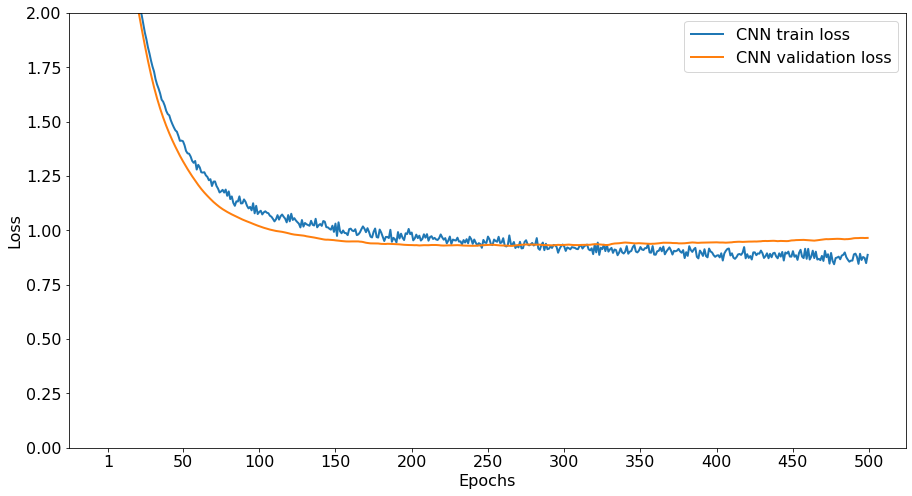

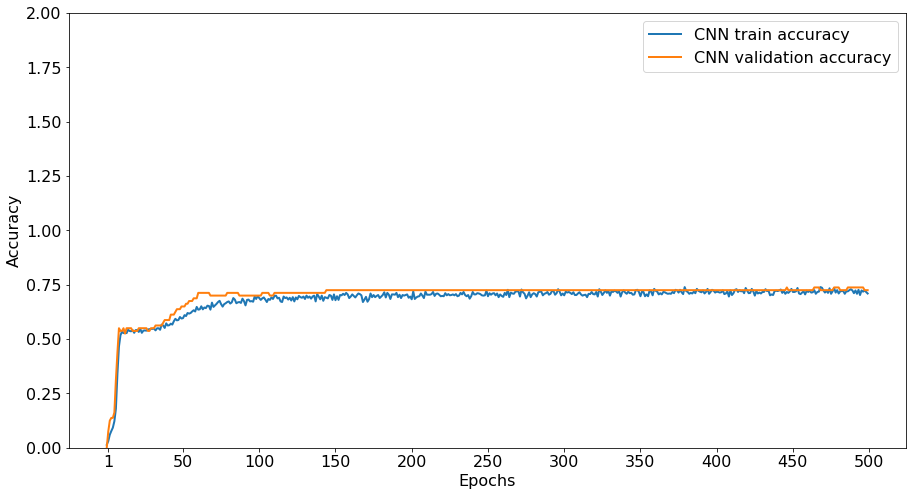

In [ ]:
print("Train Loss     : {0:.5f}".format(hist.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(hist.history['val_loss'][-1]))
print("---")
print("Train Accuracy     : {0:.5f}".format(hist.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(hist.history['val_accuracy'][-1]))


# Plot train and validation error per epoch.
plot_history(hs={'CNN': hist}, epochs=500, metric='loss')
plot_history(hs={'CNN': hist}, epochs=500, metric='accuracy')

In [ ]:
# Write predictions to a file
with open('submissions/text_ensemble_submission.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = ['id']
    for i in range(15):
        lst.append('class_'+str(i))
    writer.writerow(lst)
    for i,idx in enumerate(test_index):
        lst = yhat[i,:].tolist()
        lst.insert(0, idx)
        writer.writerow(lst)